## 리텐션 커브

<br>



In [6]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
data = pd.read_json('./advanced-bigquery-contents/dataset/weekly_retention.json').\
    sort_values('diff_of_week', ascending=True).reset_index(drop=True)

data.head()

,diff_of_week,user_cnt,first_week_user_cnt,retention_rate
0,0,35803,35803,1.00
1,1,2437,35803,0.07
2,2,2378,35803,0.07
3,3,2199,35803,0.06
4,4,1868,35803,0.05


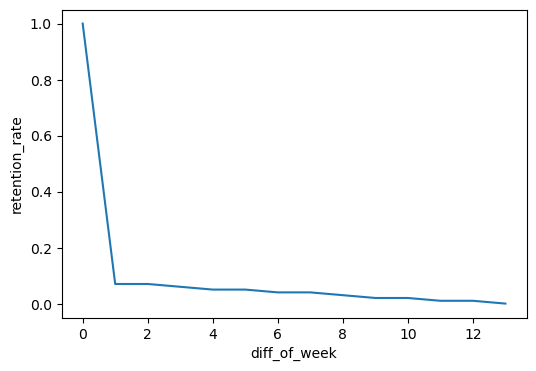

In [11]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=data, x='diff_of_week', y='retention_rate')
plt.show()

<br>

### 리텐션 커브 해석
- **이 데이터를 가지고 어떻게 의사결정? 어떤 Action?**
- **리텐션이 낮다면, 근본적인 PMF를 찾는 것을 고민**
- **자주 쓰는 사람들의 패턴은?**
- **자주 사용하지 않는 사람들의 패턴은?**

<br>

#### 리텐션 커브 현황 파악
- **1주차에 크게 감소** 

    $\rightarrow$ **제품의 핵심 가치 (PMF)가 자리잡지 않았을 수 있음**

    $\rightarrow$ **PMF를 사람들이 더 많이 경험할 수 있도록 핵심 가치 부분을 재점검**

    **+ 1주 뒤 9%만 남는 상황에 마케팅을 하는것이 의미가 있는가?**

- **2주차부턴 바로 평평**

    $\rightarrow$ **어떤 유저들은 이 핵심 가치를 경험**

    $\rightarrow$ **평평한 부분 (Retention Plateau) 부분에 있는 사람들은 주로 어떤 것을 하고 있는지 파악 (정량 분석 + 사용자 인터뷰 등)**

    $\rightarrow$ **주기적으로 사용하는 사람들의 특징을 찾고 이 부분을 핵심 가치 경험에 녹이는 것을 제안**

    (3주의 주기를 가지는 사람들을 어떻게 2주로 줄일 수 있을까?)

<br>

#### 리텐션 지표 해석
- 새로운 기능을 런칭한 후, 지표를 해석/커뮤니케이션 할 때,

    **리텐션의 시기 및 종류를, 비율을 사용해 개선 전후의 차이를 언급하는 것이 바람직**

    - 예) Day 1 리텐션이, XX % 상승

<br>

<hr>

<br>


## 코호트 리텐션

<br>

### 코호트 
- **통계적으로 동일한 특색이나 행동 양식을 공유하는 집단 (특정 기간에 가입하거나 공통 행동을 한 사용자 그룹)**
    - 보통 가입일자 기준으로 많이 파악
    
        예) 가입한지 1주차 후에도 여전히 사용하는가?
    - 코호트를 특정 이벤트 여부, 빈도로 만들 수 있음

<img src='img/04-10.jpg' width=600>

<br>

#### 코호트 Weekly 리텐션
- 각 주차 (`first_week`) 별 접속자들을 코호트로 간주

  $\rightarrow$ 코호트별 리텐션 생성

<br>

```sql
WITH base AS (
  SELECT
    DISTINCT
      user_id,
      user_pseudo_id,
      event_name,
      DATE(DATETIME(TIMESTAMP_MICROS(event_timestamp), 'Asia/Seoul')) AS event_date,
      DATETIME(TIMESTAMP_MICROS(event_timestamp), 'Asia/Seoul') AS event_datetime
  FROM advanced.app_logs
  WHERE
    event_date BETWEEN "2022-08-01" AND "2023-08-03"
), first_week_and_diff AS (
  SELECT
    *,
    DATE_DIFF(event_week, first_week, WEEK) AS weeks_after_first_week
  FROM (
    SELECT
      DISTINCT 
        user_pseudo_id,
        DATE_TRUNC(MIN(event_date) OVER(PARTITION BY user_pseudo_id), WEEK(MONDAY)) AS first_week,
        DATE_TRUNC(event_date, WEEK(MONDAY)) AS event_week
    FROM base
  )
), user_counts AS (
  SELECT
    first_week,
    weeks_after_first_week,
    COUNT(DISTINCT user_pseudo_id) AS active_users
  FROM first_week_and_diff
  GROUP BY 
    first_week,
    weeks_after_first_week
)


SELECT
  *,
  ROUND(SAFE_DIVIDE(active_users, cohort_users), 2) AS retention_rate
FROM (
  SELECT
    first_week,
    weeks_after_first_week,
    active_users,
    FIRST_VALUE(active_users) OVER(PARTITION BY first_week ORDER BY weeks_after_first_week ASC) AS cohort_users
  FROM user_counts
)
ORDER BY first_week, weeks_after_first_week
```

<img src='img/04-13.png' width=600>

<br>

<br>

#### 코호트 리텐션 해석
- **코호트 모수의 숫자가 작으면 리텐션 비율이 높게 나올 수 있음**

    $\rightarrow$ 비율과 숫자를 모두 보며 파악

- 갑자기 증가한 곳이 있는가? 왜? 제품에 어떤 점이 개선되었길레?
- 올라간 특징을 기능으로 만들 수 있는가?

<br>

- **코호트 리텐션 파악**
    - 초반에 사용한 사람들의 리텐션은 낮음
    - 2022-10-03부터 올라가고, 2022-11-28은 모두 준수
    - 2022-12-19에 감소되고 있어서, 그 다음의 주차들에 주목 필요

    $\rightarrow$ **무엇이 리텐션의 증감을 유발?**

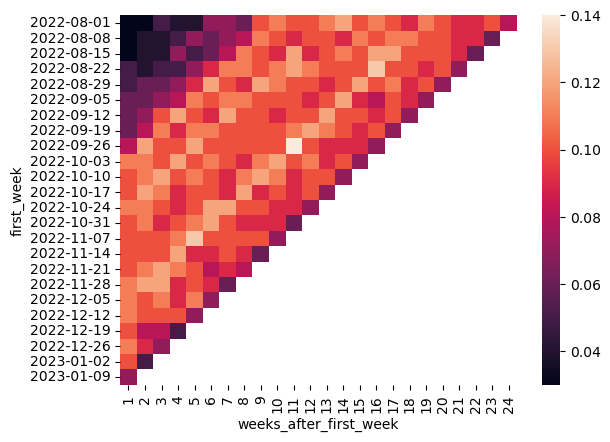

In [22]:
data = pd.read_json('./advanced-bigquery-contents/dataset/cohort_retention.json').\
    sort_values(['first_week', 'weeks_after_first_week']).reset_index(drop=True)

cohort = data.query('weeks_after_first_week > 0').\
    pivot(index='first_week', columns='weeks_after_first_week', values='retention_rate')

sns.heatmap(cohort)
plt.show()

<br>

<hr>

<br>

## 리텐션 증대 방안

<br>

### 리텐션 분석의 기본 마음가짐
- 코호트 등으로 나누어 본다음, 갑자기 수치가 좋은 경우 
    
    $\rightarrow$ 무엇이 수치 증가를 유발하였는지를 생각
    
- 특정 지역, 조건에 따라 탐색
- 너무 이전 데이터를 기반으로 찾는 경우, 지금 당장의 Action Item을 찾기 어려울 수도 있음

    $\rightarrow$ **데이터에 매몰될 필요가 없음**

<br>

### 리텐션 증대 방안

<br>

#### 제품 개선
- **고객이 해결하고자 하는 문제를 어떻게 더 잘 해결할 수 있을까?**
    - 예) 예약/주문 과정 UX 최적화

- **문제를 해결하는 과정을 습관으로 만들 수 없을까?**
    - 예) 앱 푸시 메시지 등

<br>

#### 온보딩 프로세스 개선
- **고객이 제품을 처음 사용할 때, 이 제품의 필요성을 더 느낄 수 있도록 할 수 없을까?**
    - 사용 가이드 등

- **제품의 핵심 가치를 느낀 시점은?**

    $\rightarrow$ **그 시점을 조금더 앞당길 수 있는가?**

    $\rightarrow$ **핵심 가치를 느끼지 못한 사람들도 어떻게 느끼게 할 수 있는가?**

<br>

#### 주기적 사용 유도
- **주기적으로 제품을 사용해야 하는 이유가 있는가?**
    - 예) 가격 경쟁력

    **그 이유를 까먹는다면 우리가 알려주는가?**

    $\rightarrow$ 마케팅, 앱 푸시 메시지 등

<br>

#### 이탈 방어
- 회원 탈퇴, 멤버십 해지 등을 방지
    - 예) 링크드인, 스트리밍 플랫폼 등의 탈퇴시 추가 사용 기간 지급
    
<br>

#### 고객의 문제 해결 지지
- **고객의 문제를 해결하고 있는 것을 응원하고 지지하고 있는가?**

    - 예) 듀오링고 메시지, 출석 보상 등

<br>

### 계속 사용하게 되는 제품 예시

<br>

#### [Rize](https://rize.io/)
- 시간 관리 도구
- **사용자의 해결하고자 하는 문제** : 시간관리를 하려고 하는데, 시간을 기록하는 것이 번거로움
- **주기적 사용 유도**
    - 주기적으로 메일로 데이터를 정리해서 제공
    - 집중하지 않으면 Alert창을 띄워서 집중하라고 함

<br>

#### [Whoop](https://www.whoop.com/)

- 신체의 건강 데이터를 수집하는 밴드
- **사용자의 해결하고자 하는 문제** : 건강하고 싶은데, 지금 어떤 상황인지 모르겠다
- **고객의 문제 해결 지지** : 신체 데이터를 기록할 때마다 레벨업 안내 및 기능을 점진적으로 해제
- **주기적 사용 유도**
    - 주기적으로 메일로 데이터를 정리해서 제공
    - 언제 자야 회복이 잘된다. 어제 하루 어떠했는지? 등을 기록할 수 있도록 주기적으로 알려줌

<br>

<hr>

<br>

## 리텐션 분석 유의사항

<br>

#### 제품이 익숙해야 아이디어도 잘 나옴
- 데이터 분석가의 리텐션 분석 $\rightarrow$ 만족스러운 결과가 잘 나오지 않음

    $\rightarrow$ 제품에 대한 이해가 적고, 숫자를 보면서 계속 생각하게됨

    $\rightarrow$ 어떤 것을 Action해야 할까를 생각하기 어려움

    $\rightarrow$ Action의 주체는 PO,PM일 가능성이 있음

    $\rightarrow$ 소통 필요
- **AhaMoment같이 고객이 어떤 행동을 하면 리텐션이 높은가?를 물어보는 것이 더 좋을 수 있음**
- 내가 일상에서 꾸준히 사용하는 것을 떠올리고, 역으로 생각해보기
- 일상에서 사용하는 제품에서 아이디어를 얻어 분석하는 제품에 적용할수도 있음

<br>

#### 초기 단계가 아닌 이상 리텐션을 갑자기 확 올리는 것은 어려움
- **제품이 초기 단계거나 퍼널이 적다면, 1~2개의 기능으로 리텐션이 올라갈 수 있음**
- **제품이 복잡해지면, 하나의 기능을 출시해도 리텐션이 올라가지 않을 수 있음**

    $\rightarrow$ **페르소나를 더 구체적으로 나누고, 그 페르소나에 해당하는 사람들이 원하는 기능을 만들고 리텐션이 올라가나 보는 것이 필요**
    - **목적 조직마다 리텐션 그래프를보는 것도 필요**

- 목표를 쪼개서 세우기
    - 예) 신규 유저의 Day1 리텐션 증가 목표시

        $\rightarrow$ 기존유저를 제외하고 신규유저의 리텐션을 올린 후, 그게 동작한다고 판단되면 점진적으로 기존 유저에게도 배포
- 리텐션을 드라마틱하게 올리는 경우는 정말 적음. 어려운 일인 것을 인지하며 진행

<br>

#### 리텐션 지표에 너무 매몰되지 않아도 괜찮음

- 리텐션 지표가 유용할수도 있지만, **제품의 사용주기가 길면 리텐션을 파악하기까지 시간이 오래 걸림**
    
    $\rightarrow$ 리텐션이 아니여도 괜찮을수있고, 지표를 재정의하는 것이 필요 

    - 예) 하루 단위의 지표는 앱접속자, 페이지 전환율, 해결하고자하는 핵심 이벤트 등을 파악
- 월마다 리텐션지표를 점검. 리텐션을 하루 단위로 봐도 거의 움직이지 않을 수 있음

<br>

#### 초기의 사용자 경험이 중요

- **사용자의 앱 사용 여부는 Day7도아니고, 그냥 앱설치 하루안에 결정**

    $\rightarrow$ 제품이 초기에 얼마나 지극정성인가를 생각
    
- 온보딩 과정에서 고객이 겪을 문제를 제시하며, 이걸 해결하는 방법으로 제품을 공유하며 가치를전달
- 1번 진행하고 끝이아닌, 계속 고민
- ABTest를 진행해서 경험한 사람과 아닌 사람의 차이가 존재하는지 파악

<br>

#### 습관형성에 대해 생각 (Habit Moment)
- 앱을 사용하는 것도 의식해서 해야함

    $\rightarrow$ **의식하는 것을 최대한 줄이기 (무의식적으로 앱을 사용하게)**

- 고객에게 아래 내용을 전달하고 있을까?
    - 언제 사용해야 하는가?
    - 어떤 가치를 얻을 수 있는가? 

<br>

#### 좋은 리텐션 비율은?
- **접속 주기, 리텐션의 좋다 기준은 판단이 어려움**
    
- **업계 평균을 알려고 해도 알기 어렵고, 그 내용을 알아서 얻는 것은?**
    
    $\rightarrow$ 결국 일부 지점의 한 포인트를 알게 되는 것에 불과하고, 그마저도 계절성이 있을 수 있음

    $\rightarrow$ 결국 우리의 리텐션을 계속 올리는데 집중

    $\rightarrow$ 결론 : 좋은 리텐션은 서비스 마다 다름

- 코호트 리텐션을 분석 할때, 시기에 따라 (아무것도 안했는데) 올라가는 경우가 존재 가능

    $\rightarrow$ 이런 부분을 사전에 확인하고 분석하는 것이 필요

    $\rightarrow$ 계절성에 영향을 받는 시기인지 고민해보고. 변동성을 줄이기

<br>

#### 유저 쪼개서 생각하기
- **신규 사용자 (New)** : 제품을 처음 사용하는 유저
- **기존 사용자 (Current)** : 제품을 지속적으로 사용하는 유저
- **복귀 사용자 (Resurrected)** : 과거에사용 $\rightarrow$ 비활성 $\rightarrow$ 다시 제품을 사용한 유저
- **휴면 사용자 (Dormant)** : 일정 기간 제품을 사용하지 않은 비활성화 사용자

<br>

- 유저 그룹별 문제 및 방안 수립
    - 휴면 사용자를 어떻게 복귀 사용자로 부활?
    - 어떻게 신규 사용자를 게속 늘릴 수 있을까?
    - 기존 유저가 감소하지 않으려면?

<img src='img/04-14.jpg' width=600>

<br>

#### 리텐션을 올리기 위한 여러 아이디어
- 온보딩개선
- 문제해결의 가치 제공하기
- 커뮤니티 만들기 : 접속주기를 줄이기 위함 (예: 오늘의 집, 강남언니 등)
- 습관을 만들기 위해 도움 주기 : 적절한 Push (예: 듀오링고 등 )
- 잘하고 있다고 응원하기, 얼마 안남았다고 이야기하기 (예: 듀오링고 등)
- 게이미피케이션 : 사용자 흥미유발
- 함께 진행하기, 소셜 기능
- CRM : 오래 학습하지 않으면 연락
- 손실회피 자극하기 (예: 금융 앱 등)
- 심리학, 의사결정등에서 아이디어를 얻고 실험

<br>

### 리텐션의 핵심
- **리텐션은 후행 지표**
- 여러 요소가 연결되어서 나오는 결과
- 리텐션의 차이가 나는 곳이 있을까? 우리가 그것을 적용할 수 있을까?
- 어떻게 해야 더 사람들이 잘 사용하게 될까?
- 이후 Action은 혼자가 아닌 같이 만드는 것
- 리텐션 분석에 너무 시간을 오래쓰는 것 보단, 주기적으로 PM과 미팅하면서 개선하는 것에 초점

<br>

<hr>